# Read Data

In [1]:
df <- read.table('./Dataset/fertility_Diagnosis.txt', sep = ",")
attrbs = c('season','age','childhood_disease','trauma','surgeries','high_fever','alcoholic','smoking','sitting','diag_result')
colnames(df) <- attrbs

df <- transform(df, season = as.factor(season), 
                    childhood_disease = as.factor(childhood_disease),
                    trauma = as.factor(trauma),
                    surgeries = as.factor(surgeries),
                    high_fever = as.factor(high_fever), 
                    alcoholic = as.factor(alcoholic),
                    smoking = as.factor(smoking), 
                    diag_result = as.factor(diag_result))

In [2]:
head(df)

season,age,childhood_disease,trauma,surgeries,high_fever,alcoholic,smoking,sitting,diag_result
-0.33,0.69,0,1,1,0,0.8,0,0.88,N
-0.33,0.94,1,0,1,0,0.8,1,0.31,O
-0.33,0.50,1,0,0,0,1,-1,0.50,N
-0.33,0.75,0,1,1,0,1,-1,0.38,N
-0.33,0.67,1,1,0,0,0.8,-1,0.50,O
-0.33,0.67,1,0,1,0,0.8,0,0.50,N


In [3]:
str(df)

'data.frame':	100 obs. of  10 variables:
 $ season           : Factor w/ 4 levels "-1","-0.33","0.33",..: 2 2 2 2 2 2 2 2 4 4 ...
 $ age              : num  0.69 0.94 0.5 0.75 0.67 0.67 0.67 1 0.64 0.61 ...
 $ childhood_disease: Factor w/ 2 levels "0","1": 1 2 2 1 2 2 1 2 1 2 ...
 $ trauma           : Factor w/ 2 levels "0","1": 2 1 1 2 2 1 1 2 1 1 ...
 $ surgeries        : Factor w/ 2 levels "0","1": 2 2 1 2 1 2 1 2 2 1 ...
 $ high_fever       : Factor w/ 3 levels "-1","0","1": 2 2 2 2 2 2 1 2 2 2 ...
 $ alcoholic        : Factor w/ 5 levels "0.2","0.4","0.6",..: 4 4 5 5 4 4 4 3 4 5 ...
 $ smoking          : Factor w/ 3 levels "-1","0","1": 2 3 1 1 1 2 1 1 1 1 ...
 $ sitting          : num  0.88 0.31 0.5 0.38 0.5 0.5 0.44 0.38 0.25 0.25 ...
 $ diag_result      : Factor w/ 2 levels "N","O": 1 2 1 1 2 1 1 1 1 1 ...


In [4]:
library("rjags")
library("coda")

Warning message:
"package 'rjags' was built under R version 3.4.4"Loading required package: coda
Warning message:
"package 'coda' was built under R version 3.4.4"Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


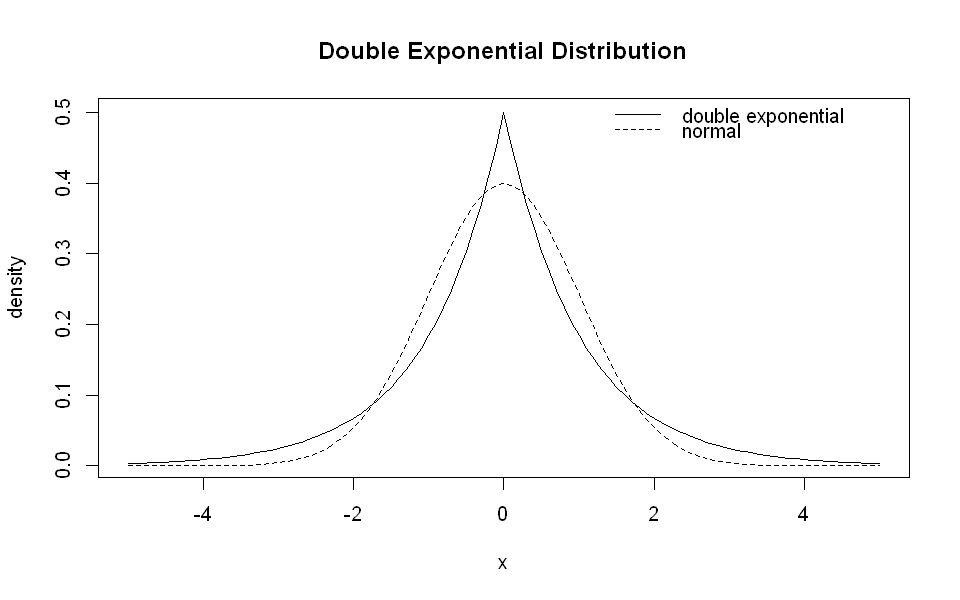

In [5]:
# The prior which I'm going to use is double exponential prior or Laplacian Prior. It favous values near zero.

ddexp = function(x, mu, tau){
    0.5*tau*exp(-tau*abs(x-mu))
}

rdexp = function(n, mu, tau){
    x = rnorm(n, 0.0, tau/sqrt(2))
    0.5*tau*exp(-tau*abs(x-mu))
}

options(repr.plot.width=8, repr.plot.height=5)

curve(ddexp(x, mu=0, tau=1.0), from=-5.0, to=5.0, ylab="density", main="Double Exponential Distribution")
curve(dnorm(x, mean=0, sd=1.0), from=-5.0, to=5.0, lty=2, add=TRUE)
legend("topright", legend = c("double exponential", "normal"), lty=c(1, 2), bty="n")

# Multi Way Additive Model

In [6]:
data_jags = list(
                    isSeasonA = as.integer(df$season == -1),
                    isSeasonB = as.integer(df$season == -0.33),
                    isSeasonC = as.integer(df$season == 0.33),
                    isSeasonD = as.integer(df$season == 1),
                    age = df$age,
                    isChildD = as.integer(df$childhood_disease)-1,
                    isTrauma = as.integer(df$trauma)-1,
                    isSurgery = as.integer(df$surgeries)-1,
                    isHighFeverA = as.integer(df$high_fever == -1),
                    isHighFeverB = as.integer(df$high_fever == 0),
                    isHighFeverC = as.integer(df$high_fever == 1),
                    isAlchoholicA = as.integer(df$alcoholic == 0.2),
                    isAlchoholicB = as.integer(df$alcoholic == 0.4),
                    isAlchoholicC = as.integer(df$alcoholic == 0.6),
                    isAlchoholicD = as.integer(df$alcoholic == 0.8),
                    isAlchoholicE = as.integer(df$alcoholic == 1),
                    isSmokerA = as.integer(df$smoking == -1),
                    isSmokerB = as.integer(df$smoking == 01),
                    isSmokerC = as.integer(df$smoking == 1),
                    sitting = df$sitting,
                    result = as.integer(df$diag_result == 'O')
                )

In [7]:
params = c("int", "beta")

In [8]:
inits = function(){
    inits = list("int" = rnorm(1,0.0,100.0),
                 "beta" = rdexp(20, 0.0, 100.0))
}

In [9]:
mod1 = jags.model(file = "Models//Model1.jags", 
                  data = data_jags,
                  #inits = inits,
                  n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 100
   Unobserved stochastic nodes: 21
   Total graph size: 2393

Initializing model



In [10]:
update(mod1, 1e3)

In [11]:
mod_1_sim = coda.samples(model = mod1, 
                         variable.names = params, 
                         n.iter = 1e4)

In [12]:
mod_1_csim = as.mcmc(do.call(rbind, mod_1_sim))

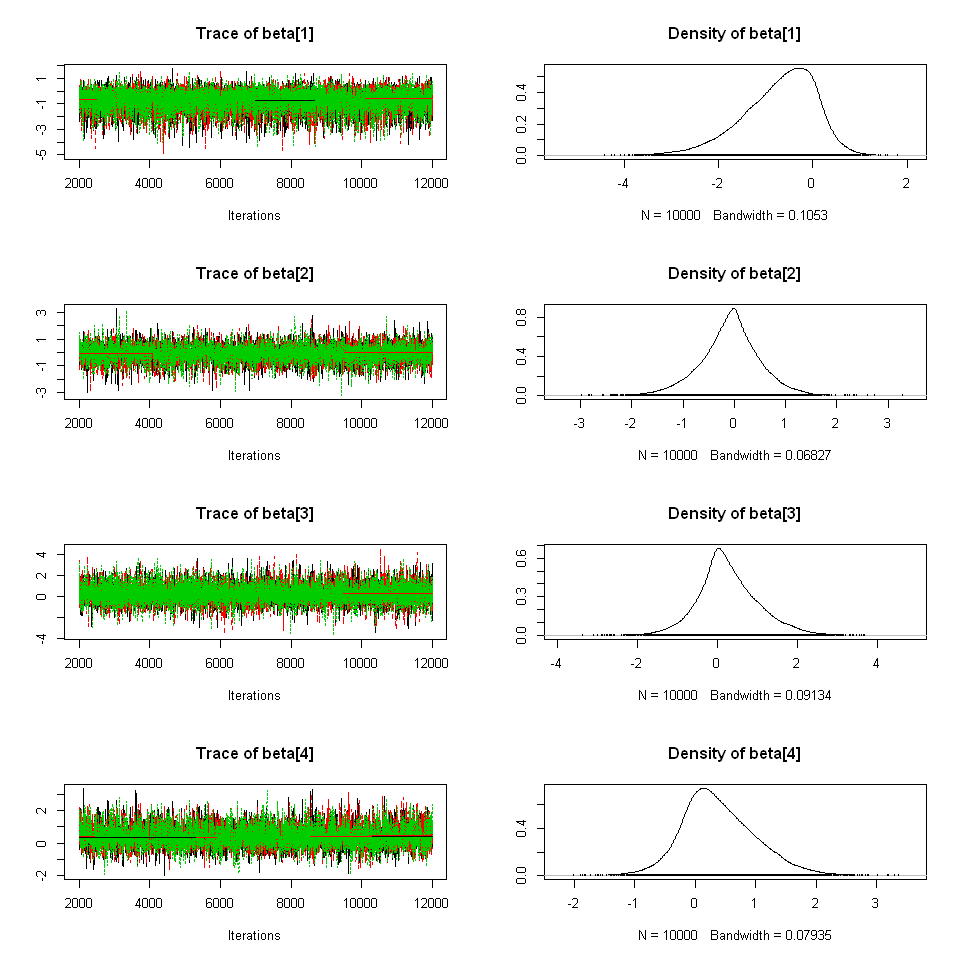

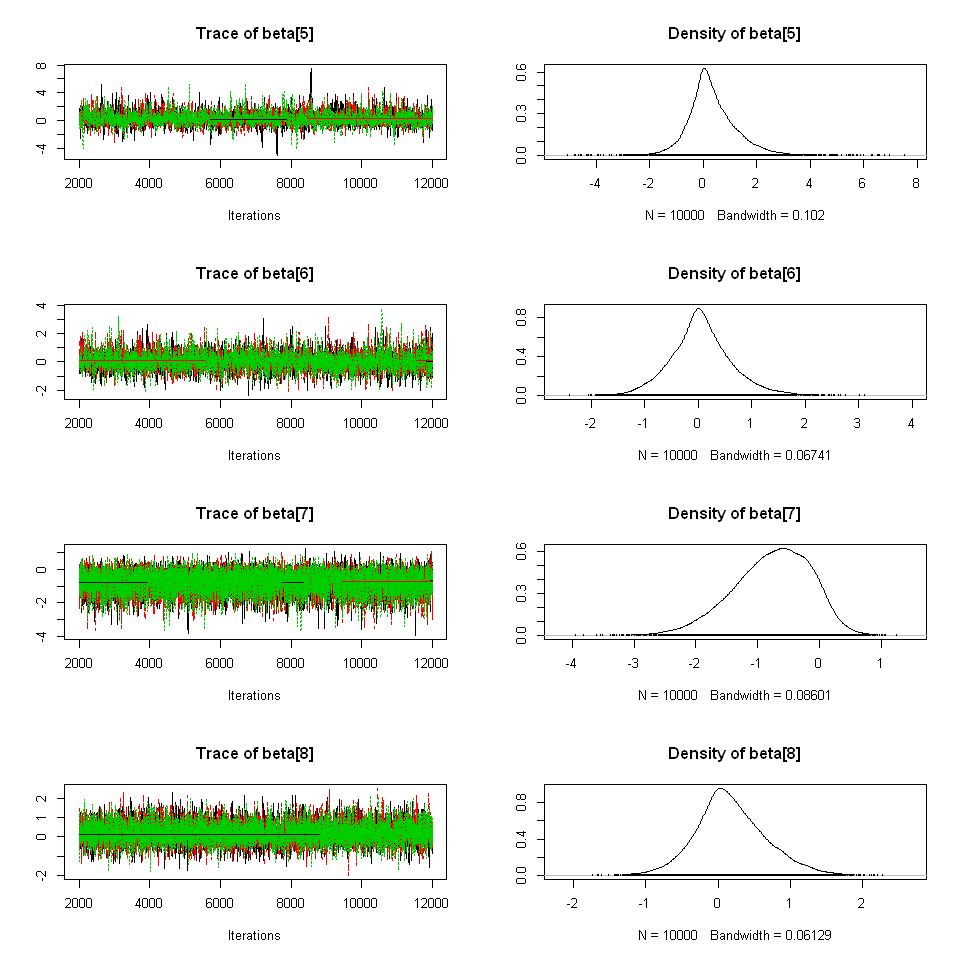

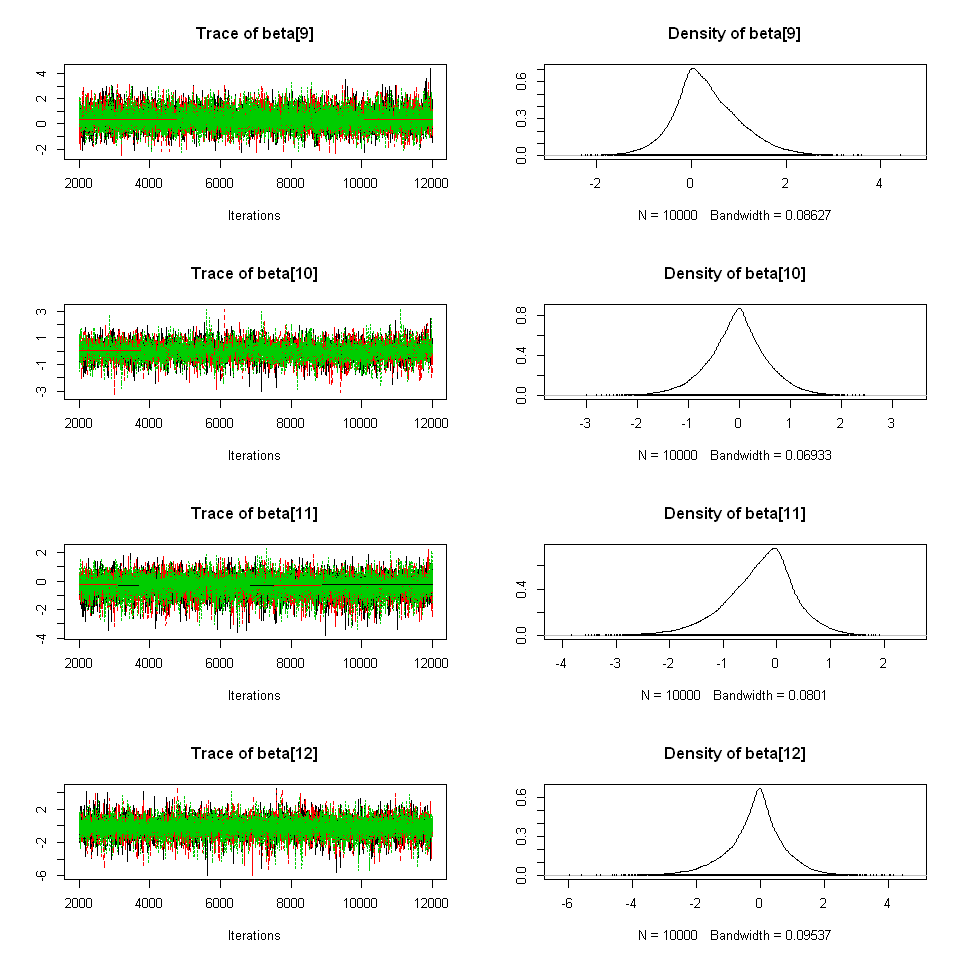

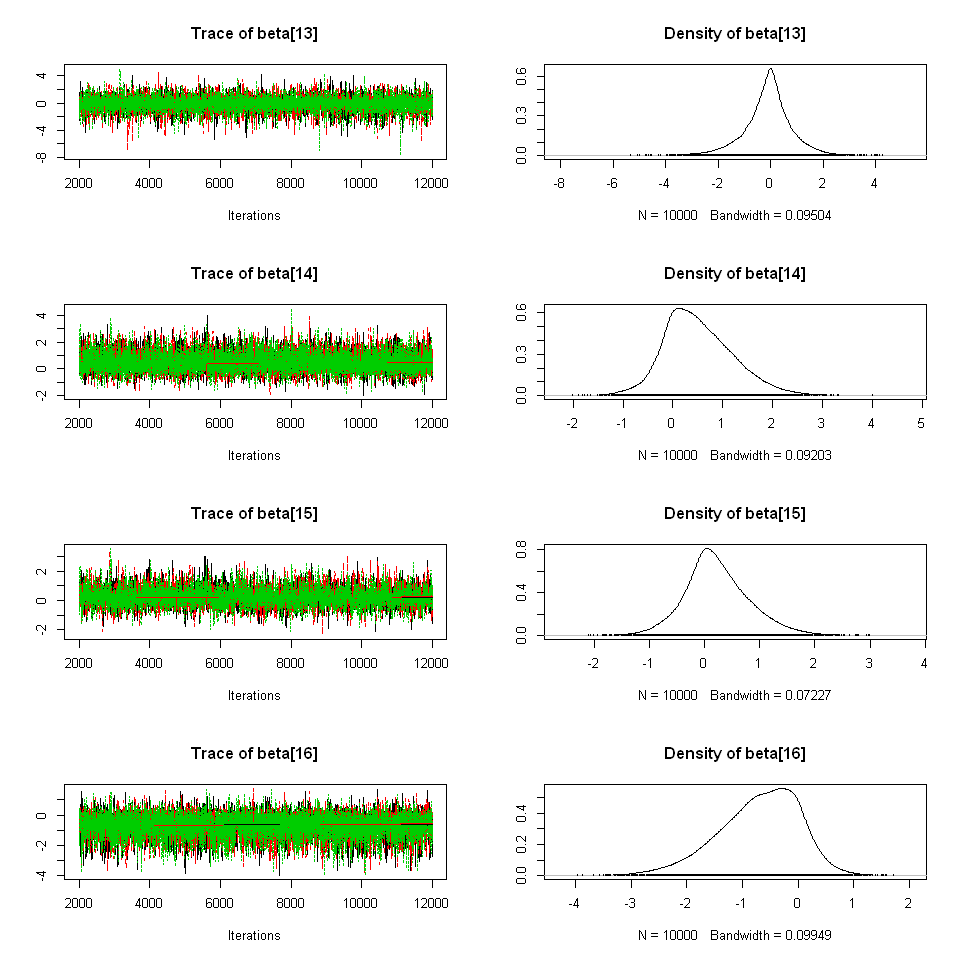

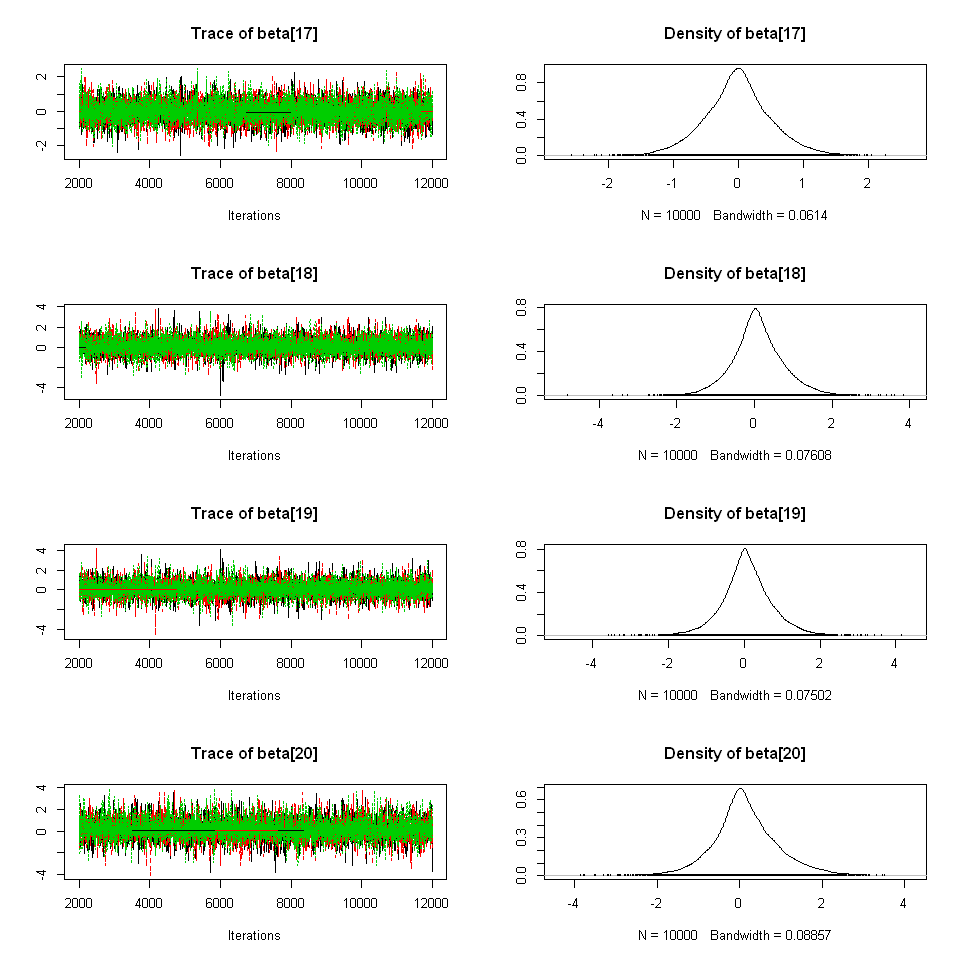

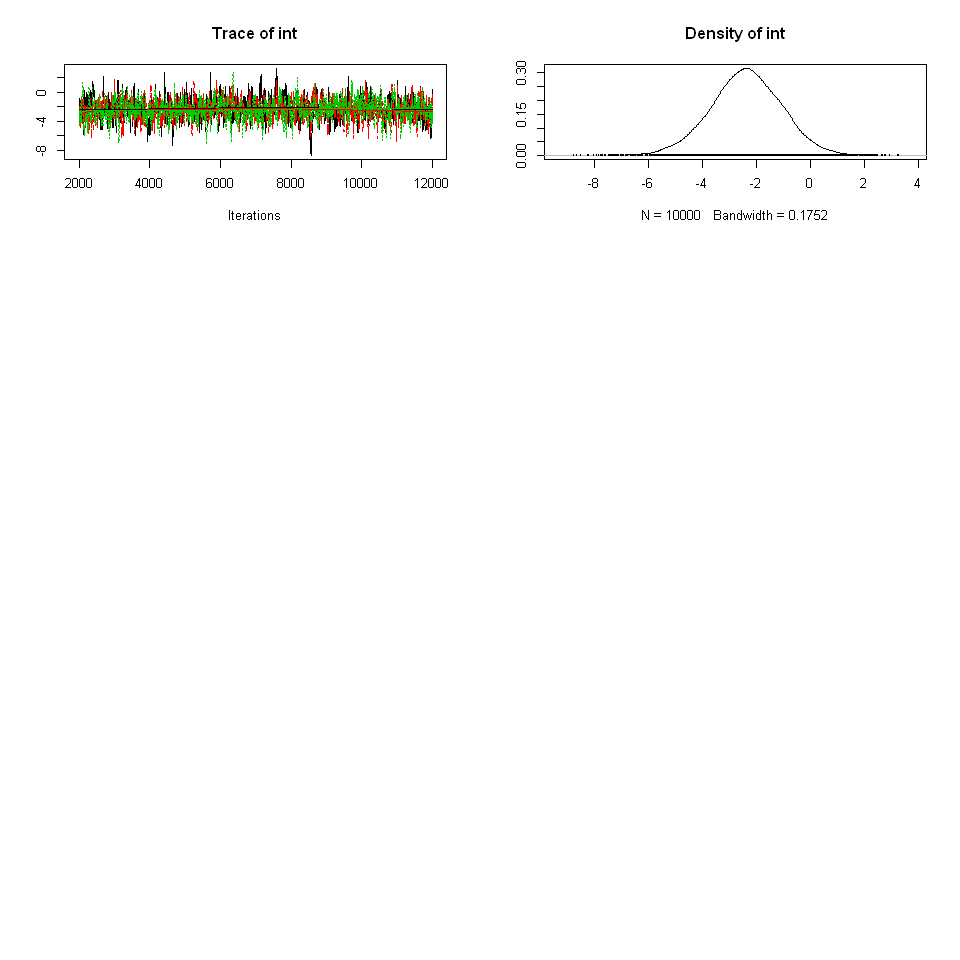

In [13]:
options(repr.plot.width=8, repr.plot.height=8)

plot(mod_1_sim)

In [14]:
gelman.diag(mod_1_sim)

Potential scale reduction factors:

         Point est. Upper C.I.
beta[1]        1.00       1.00
beta[2]        1.00       1.00
beta[3]        1.00       1.00
beta[4]        1.00       1.00
beta[5]        1.01       1.01
beta[6]        1.00       1.00
beta[7]        1.00       1.00
beta[8]        1.00       1.00
beta[9]        1.00       1.00
beta[10]       1.00       1.00
beta[11]       1.00       1.00
beta[12]       1.00       1.00
beta[13]       1.00       1.00
beta[14]       1.00       1.00
beta[15]       1.00       1.00
beta[16]       1.00       1.00
beta[17]       1.00       1.01
beta[18]       1.00       1.00
beta[19]       1.00       1.00
beta[20]       1.00       1.00
int            1.01       1.02

Multivariate psrf

1

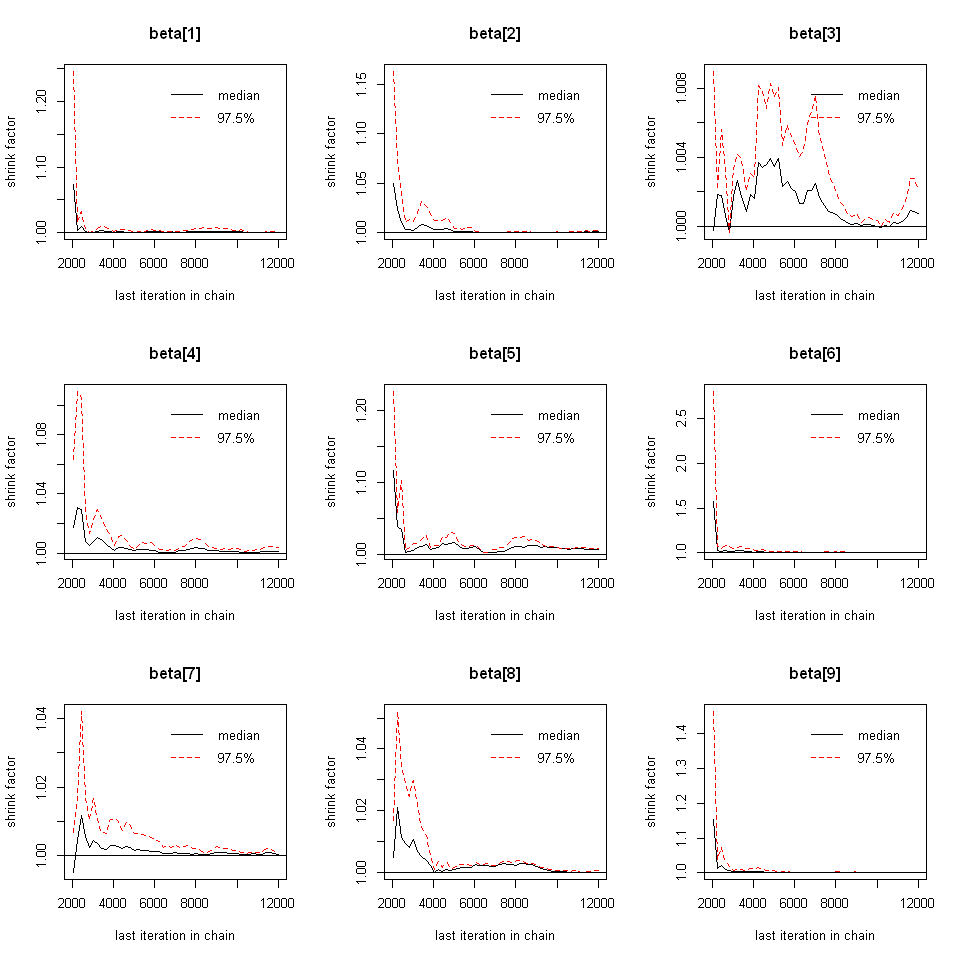

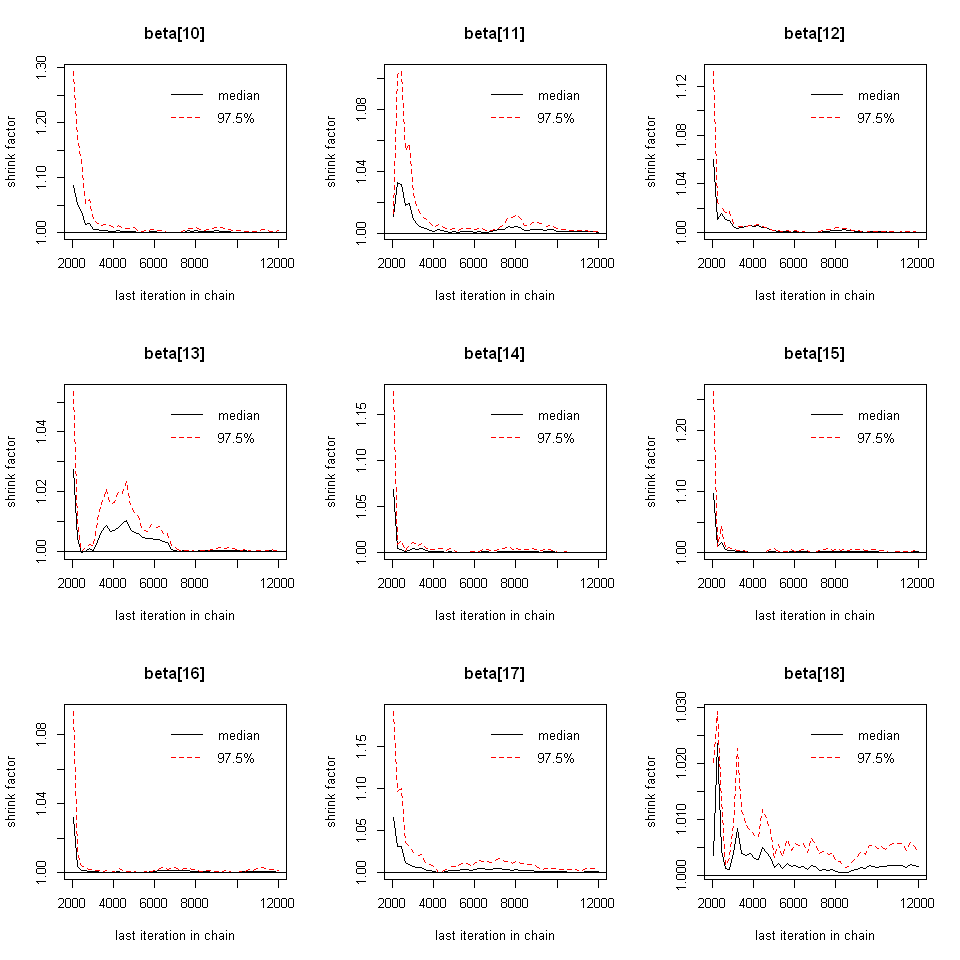

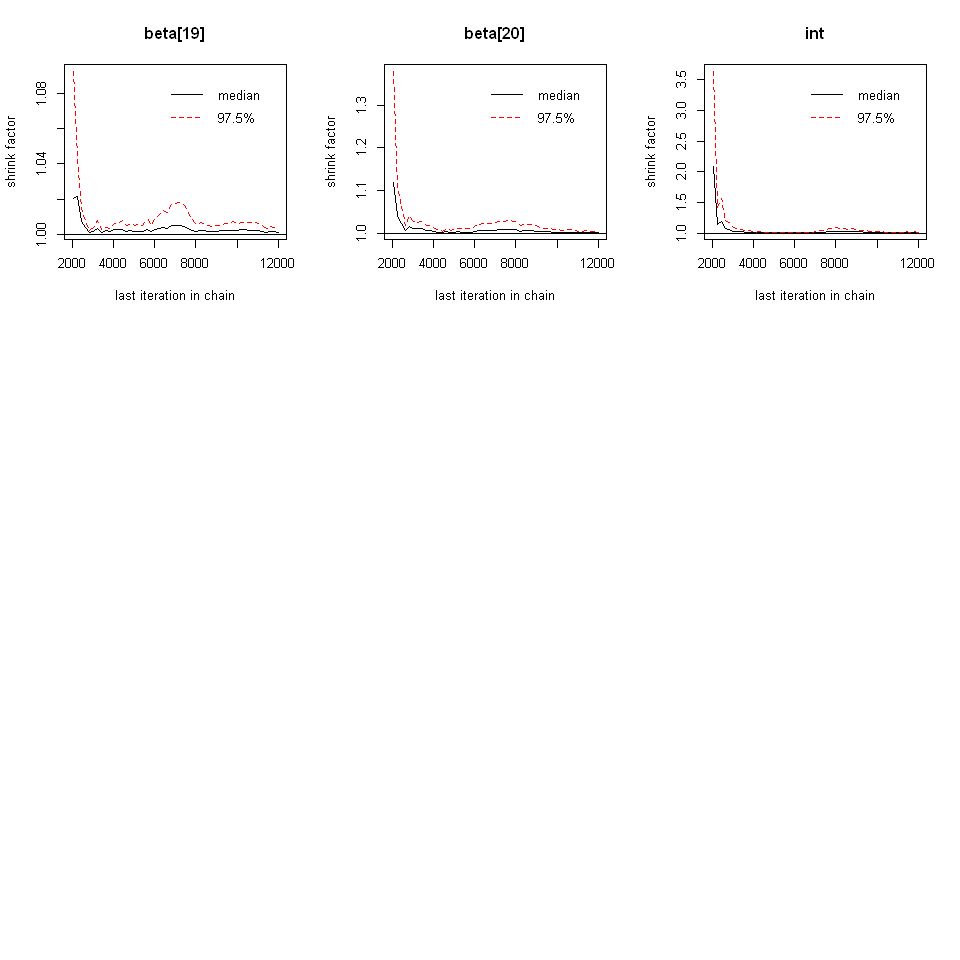

In [15]:
gelman.plot(mod_1_sim)

In [16]:
effectiveSize(mod_1_sim)

beta[1]   beta[2]   beta[3]   beta[4]   beta[5]   beta[6]   beta[7]   beta[8] 
 7963.320  6005.573 13048.338  4956.884  2281.083  3709.024  9616.856  8439.127 
  beta[9]  beta[10]  beta[11]  beta[12]  beta[13]  beta[14]  beta[15]  beta[16] 
 9016.853  3911.901  6041.478 12930.695 13320.455  5993.102  4136.210  5773.971 
 beta[17]  beta[18]  beta[19]  beta[20]       int 
 6664.807  7604.112  7204.888  6786.661   840.974

In [17]:
autocorr.diag(mod_1_sim)

,beta[1],beta[2],beta[3],beta[4],beta[5],beta[6],beta[7],beta[8],beta[9],beta[10],...,beta[12],beta[13],beta[14],beta[15],beta[16],beta[17],beta[18],beta[19],beta[20],int
Lag 0,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,...,1.00000000,1.000000000,1.000000000,1.000000000,1.000000000,1.00000000,1.000000000,1.000000000,1.000000000,1.0000000
Lag 1,0.494491160,0.579601629,0.344787450,0.611616257,0.847565380,0.773452097,0.524371784,0.560901077,0.393515023,0.737421171,...,0.36102976,0.376617608,0.534262528,0.645471596,0.575812730,0.59880790,0.562264475,0.562617839,0.631034912,0.9525964
Lag 5,0.101187564,0.141567081,0.027473683,0.205143319,0.463206271,0.292736824,0.032893728,0.057390381,0.079550820,0.269731574,...,0.00123628,0.012800059,0.155350895,0.231802106,0.159397565,0.11623413,0.094081736,0.107579741,0.119332638,0.7714086
Lag 10,0.022516881,0.036777585,-0.007098296,0.068969330,0.242274568,0.089147554,-0.002654448,0.012179202,0.031126009,0.090269169,...,-0.00316166,-0.001607729,0.047239564,0.090593700,0.056327701,0.03359707,-0.003591022,0.019208392,0.047520126,0.5695718
Lag 50,-0.001490886,0.009221777,-0.004139193,0.001979856,0.002148143,-0.008476724,0.003408159,-0.002293004,-0.004358096,-0.009103703,...,-0.01299889,-0.002657327,-0.009765487,0.009773083,0.007872669,-0.01167311,-0.001188736,-0.006161267,-0.008913089,0.0125892


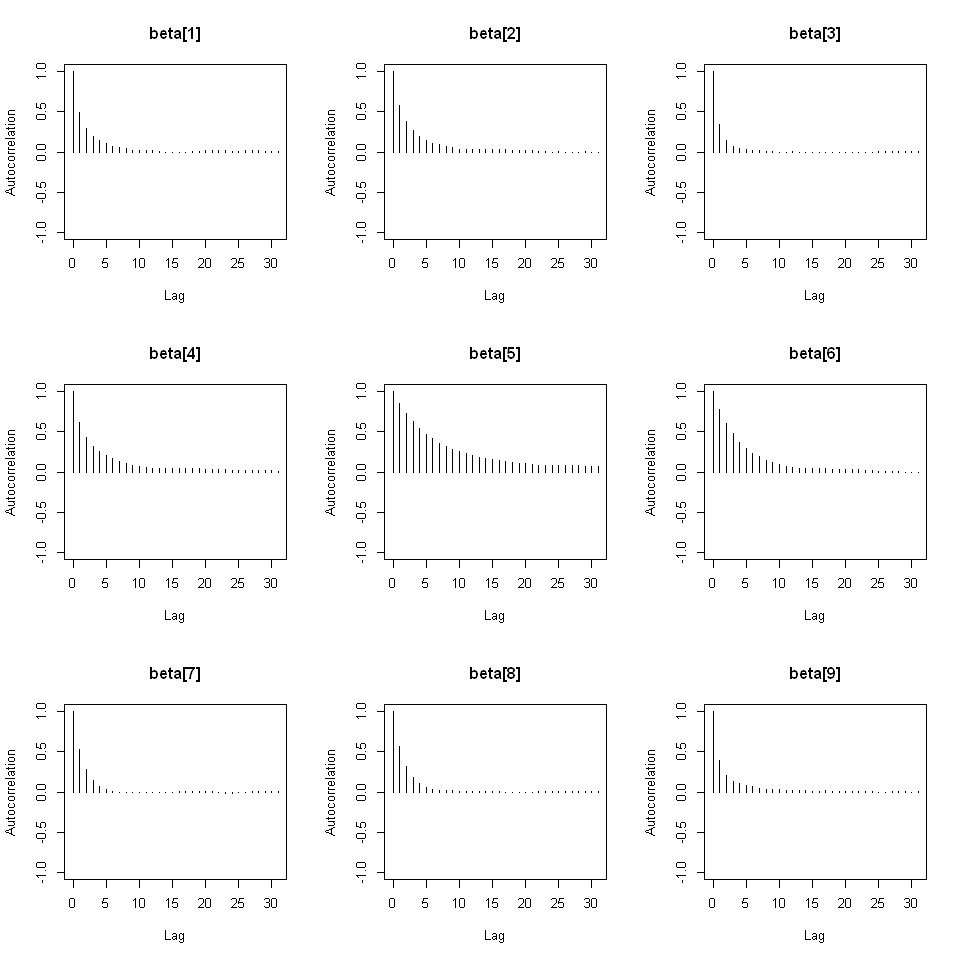

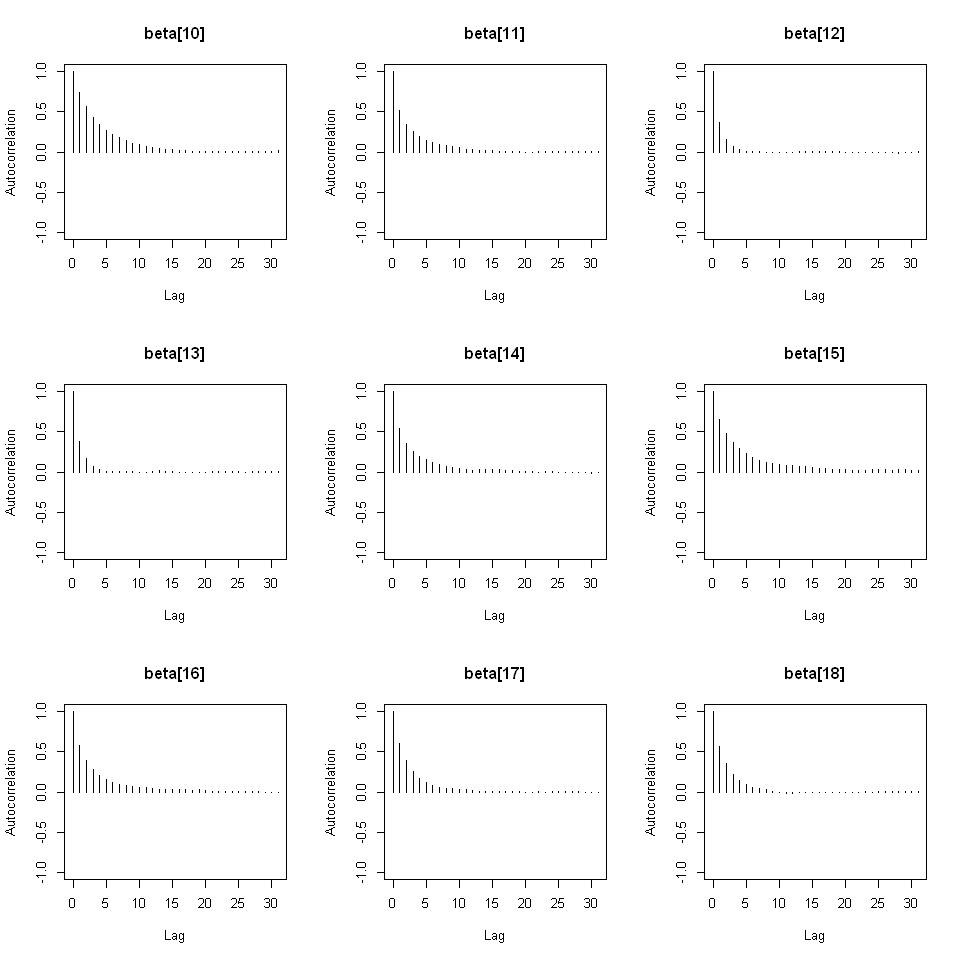

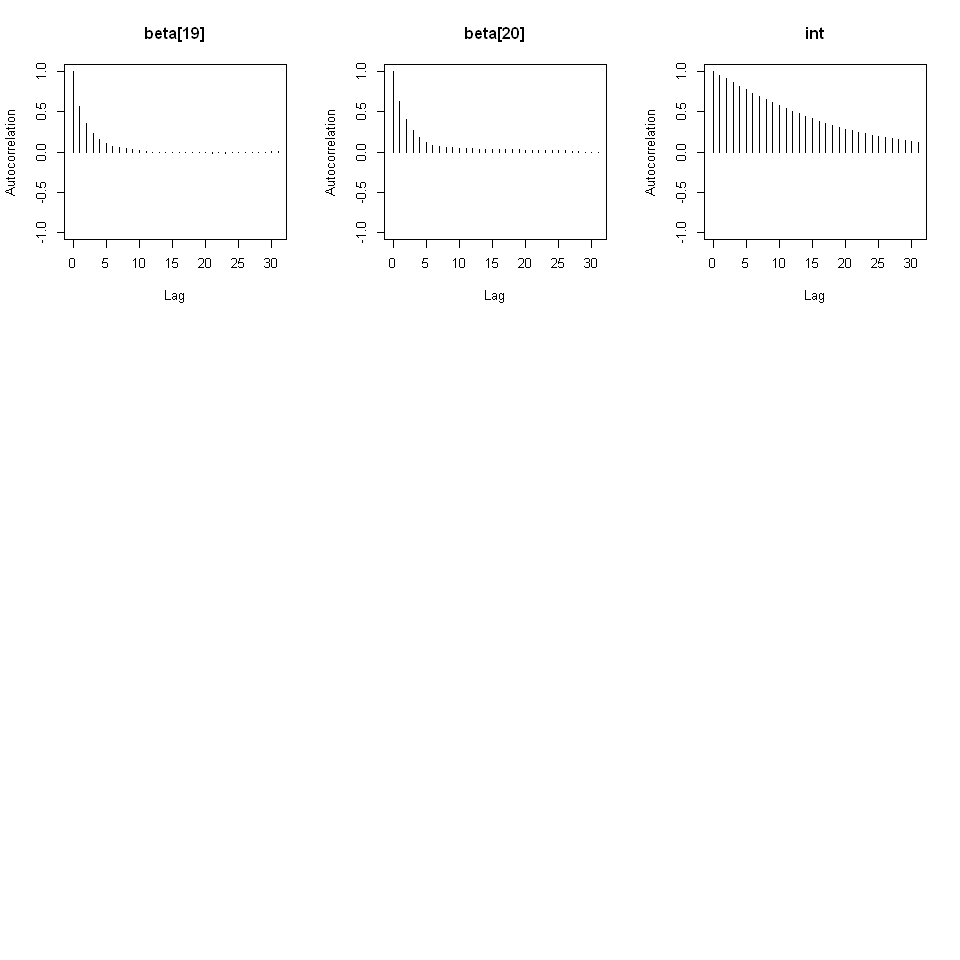

In [18]:
autocorr.plot(mod_1_csim)

In [19]:
dic.samples(model = mod1, n.iter = 1e4)

Mean deviance:  70.25 
penalty 8.176 
Penalized deviance: 78.42 